* Note: This code was runned on google colab

# Scraping Tweet

In [ ]:
# Import required Python package
!pip install pandas

# Install Node.js
!sudo apt-get update
!sudo apt-get install -y ca-certificates curl gnupg
!sudo mkdir -p /etc/apt/keyrings
!curl -fsSL https://deb.nodesource.com/gpgkey/nodesource-repo.gpg.key | sudo gpg --dearmor -o /etc/apt/keyrings/nodesource.gpg

!NODE_MAJOR=20 && echo "deb [signed-by=/etc/apt/keyrings/nodesource.gpg] https://deb.nodesource.com/node_$NODE_MAJOR.x nodistro main" | sudo tee /etc/apt/sources.list.d/nodesource.list

!sudo apt-get update
!sudo apt-get install nodejs -y

!node -v

In [ ]:
import subprocess
import os
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

twitter_auth_token = "Your_auth_token"

banks = ['btn syariah', 'jago syariah', 'maybank syariah', 'mega syariah', 'bsi', 'cimb niaga syariah', "bca syariah"]
end_date = datetime(2025, 5, 24) # adjust accordingly

for bank in banks:
    base_filename = bank.replace(" ", "_")
    for i in range(5):  # 5 periods, every 3 months
        month_end = end_date - relativedelta(months=i * 3)
        month_start = (month_end - relativedelta(months=2)).replace(day=1)

        since = month_start.strftime("%Y-%m-%d")
        until = (month_end.replace(day=1) + relativedelta(months=1) - timedelta(days=1)).strftime("%Y-%m-%d")

        filename = f"{base_filename}_{since}_to_{until}.csv"
        search_keyword = f'\\"{bank}\\" since:{since} until:{until} lang:id'
        limit = 200

        cmd = f'npx -y tweet-harvest@2.6.1 -o "{filename}" -s "{search_keyword}" --tab "TOP" -l {limit} --token {twitter_auth_token}'
        print(f"Running tweet-harvest for {bank} from {since} to {until}")
        print(cmd)

        !{cmd}

# Check if all scraped csv have the correct header

Kadang beberapa file csv tidak memiliki header, cek satu persatu dan perbaiki jika perlu

In [ ]:
# Cek File
df = pd.read_csv("tweets-data/mega_syariah_2025-03-01_to_2025-05-31.csv")
df.head()

In [ ]:
import pandas as pd

# Correct column
columns = [
    "conversation_id_str", "created_at", "favorite_count", "full_text", "id_str", "image_url",
    "in_reply_to_screen_name", "lang", "location", "quote_count", "reply_count",
    "retweet_count", "tweet_url", "user_id_str", "username"
]

# File path
file_path = "tweets-data/mega_syariah_2025-03-01_to_2025-05-31.csv" # Contoh

df = pd.read_csv(file_path, header=None, names=columns)

# Overwrite original file
df.to_csv(file_path, index=False)

print("File replaced with correct header")


# Merge and sort each bank data

In [ ]:
import os
import glob
import pandas as pd

# List of banks
banks = ['btn syariah', 'jago syariah', 'maybank syariah', 'mega syariah', 'bsi', 'cimb niaga syariah', 'bca syariah']

# Set folder path
folder_path = "tweets-data/"

# Loop over each bank
for bank in banks:
    base_name = bank.replace(" ", "_")
    file_pattern = os.path.join(folder_path, f"{base_name}_*.csv")
    csv_files = glob.glob(file_pattern)

    dataframes = []

    for file in csv_files:
        if os.path.getsize(file) > 0:  # Skip empty files
            try:
                df = pd.read_csv(file)
                dataframes.append(df)
            except Exception as e:
                print(f"Error reading {file}: {e}")
        else:
            print(f"Skipped empty file: {file}")

    if dataframes:
        merged_df = pd.concat(dataframes, ignore_index=True)

        # Convert and sort by 'created_at' timestamp
        merged_df['date'] = pd.to_datetime(merged_df['created_at'], errors='coerce')
        merged_df = merged_df.sort_values(by='date')

        # Save the merged file
        output_file = os.path.join(folder_path, f"merged_{base_name}.csv")
        merged_df.to_csv(output_file, index=False)
        print(f"Merged file saved to {output_file}")

        # Preview first few rows
        print(merged_df.head(2))
    else:
        print(f"ℹNo valid CSV files to merge for {bank}")


In [ ]:
import os
import pandas as pd

# List of banks
banks = ['btn syariah', 'jago syariah', 'maybank syariah', 'mega syariah', 'bsi', 'cimb niaga syariah', 'bca syariah']

# Source folder
source_folder = "tweets-data"

# Engagement columns
engagement_cols = ["favorite_count", "quote_count", "reply_count", "retweet_count"]

for bank in banks:
    base_name = bank.replace(" ", "_")
    file_path = os.path.join(source_folder, f"merged_{base_name}.csv")

    if not os.path.exists(file_path):
        print(f"⚠️ File not found: {file_path}")
        continue

    try:
        df = pd.read_csv(file_path)

        # Fill and convert engagement columns
        df[engagement_cols] = df[engagement_cols].fillna(0)
        df[engagement_cols] = df[engagement_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

        # Calculate total engagement
        df["total_engagement"] = df["favorite_count"] + df["quote_count"] + df["reply_count"] + df["retweet_count"]

        # Sort by total engagement and take top 55
        df_sorted = df.sort_values(by="total_engagement", ascending=False)
        df_top_55 = df_sorted.head(70)

        # Create output directory if it doesn't exist
        output_folder = os.path.join(source_folder, "Engagement Sorted")
        os.makedirs(output_folder, exist_ok=True)

        # Save the result
        output_path = os.path.join(output_folder, f"sorted_merged_{base_name}.csv")
        df_top_55.to_csv(output_path, index=False)

        print(f"✅ Top 55 saved for {bank} → {output_path}")
        print(df_top_55[["full_text", "total_engagement"]].head())

    except Exception as e:
        print(f"❌ Error processing {file_path}: {e}")


# Merge all  bank csv

In [ ]:
import pandas as pd
import os
import re

# Define the folder containing all sorted CSVs
sorted_folder = 'tweets-data/Engagement Sorted'

# List all CSV files in the folder
csv_files = [f for f in os.listdir(sorted_folder) if f.endswith('.csv')]

# List to hold individual DataFrames
df_list = []

# Columns you want to keep
columns_to_keep = [
    "bank_name", "created_at", "full_text", "favorite_count", "quote_count",
    "reply_count", "retweet_count", "total_engagement"
]

# Loop through each CSV file
for file in csv_files:
    file_path = os.path.join(sorted_folder, file)

    # Read the CSV
    df = pd.read_csv(file_path)

    # Extract bank_name using regex: extract what's between "merged_" and "_syariah"
    match = re.search(r'sorted_merged_(.*?)_syariah', file)
    if match:
        bank_name = match.group(1).lower()
    else:
        bank_name = "unknown"

    # Add the bank_name column
    df["bank_name"] = bank_name

    # Add missing columns with default values (empty strings or 0 for numeric columns)
    for col in columns_to_keep:
        if col not in df.columns:
            if col in ["favorite_count", "quote_count", "reply_count", "retweet_count", "total_engagement"]:
                df[col] = 0
            else:
                df[col] = ""

    # Select only the relevant columns (order them as in columns_to_keep)
    df = df[columns_to_keep]

    # Append to the list
    df_list.append(df)

# Concatenate all DataFrames
combined_df = pd.concat(df_list, ignore_index=True)

# Save to a single CSV
output_path = 'tweets-data/Engagement Sorted/combined_sorted_engagement.csv'
combined_df.to_csv(output_path, index=False)

# Preview result
print(combined_df.head())


# Categorizing Sentiment and Tweet Type

Untuk kagorisasi "sentimen" dan "Category" dalam data kami, kami lakukan secara manual.

## Sentiment Analysis

## Visualization

### Tweet Category Dist.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Path to your file
file_path = "tweets-data/Engagement Sorted/combined_sorted_engagement-v3.csv"
df = pd.read_csv(file_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<Figure size 1200x600 with 0 Axes>

<ipython-input-13-cfa777d9b6c0>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=engagement_per_bank, x="bank_name", y="total_engagement", palette="mako")


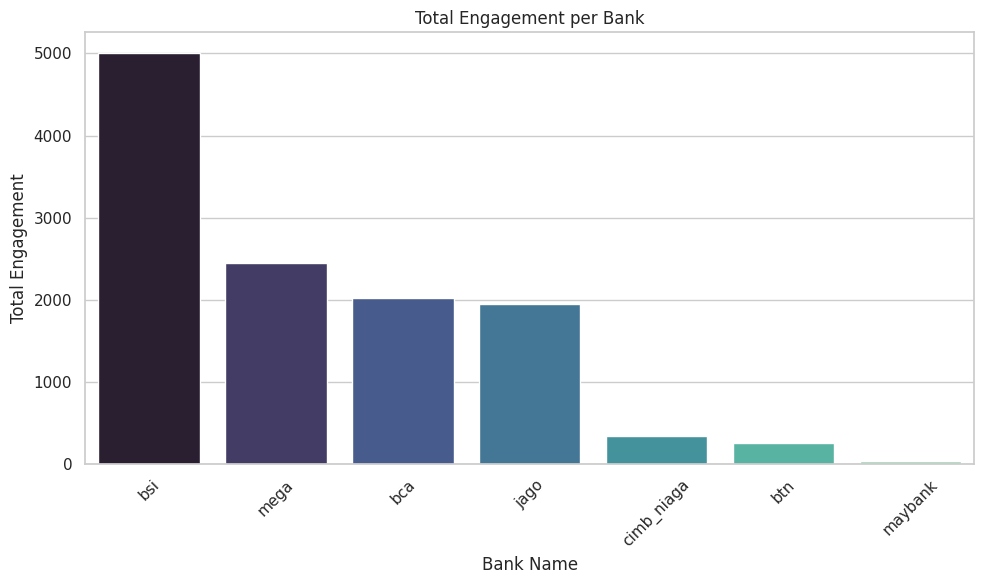

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the style
sns.set(style="whitegrid")

# Aggregate total engagement per bank
engagement_per_bank = df.groupby("bank_name")["total_engagement"].sum().reset_index()

# Sort values (optional)
engagement_per_bank = engagement_per_bank.sort_values("total_engagement", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=engagement_per_bank, x="bank_name", y="total_engagement", palette="mako")
plt.title("Total Engagement per Bank")
plt.xlabel("Bank Name")
plt.ylabel("Total Engagement")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


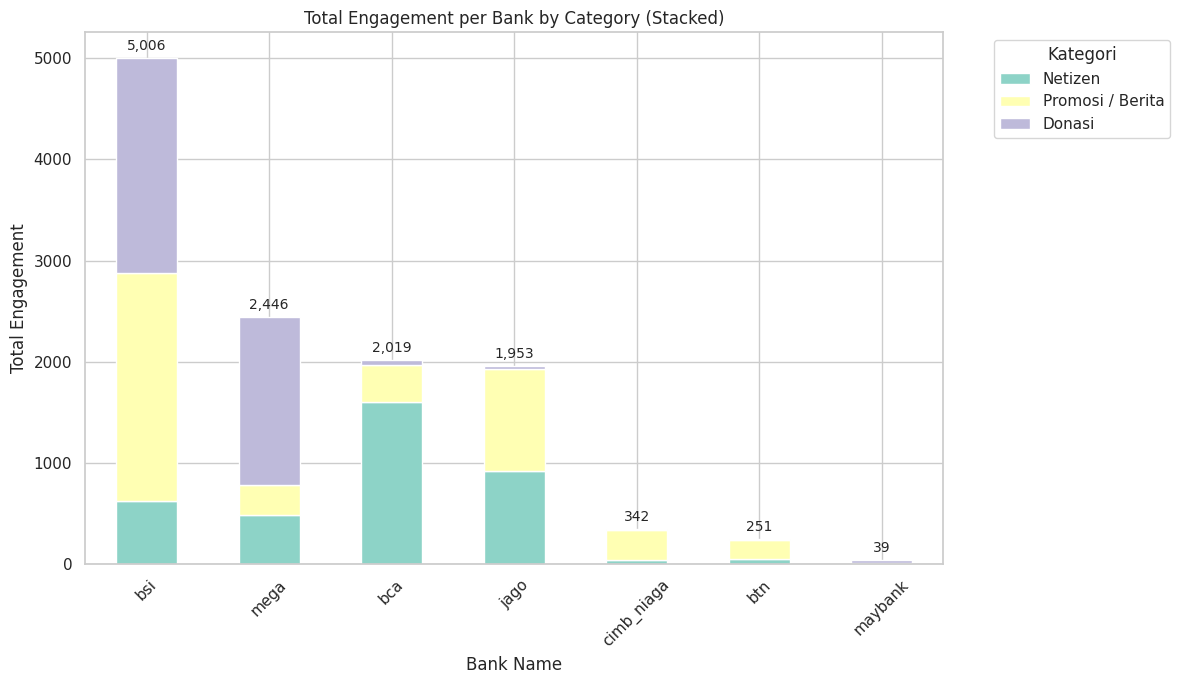

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare pivot table: sum of engagement by bank and category
stacked_data = df.pivot_table(
    index="bank_name",
    columns="Category",
    values="total_engagement",
    aggfunc="sum",
    fill_value=0
)

# Categories
categories = stacked_data.columns.tolist()
custom_labels = {
    categories[0]: "Netizen",             # Category 1
    categories[1]: "Promosi / Berita",    # Category 2
    categories[2]: "Donasi"               # Category 3
}

# Set consistent colors from Set3
cmap = plt.get_cmap('Set3')
colors_list = [cmap(i) for i in range(len(categories))]
color_map = dict(zip(categories, colors_list))

# Sort data by total engagement
stacked_data_sorted = stacked_data.copy()
stacked_data_sorted["Total"] = stacked_data_sorted.sum(axis=1)
stacked_data_sorted = stacked_data_sorted.sort_values("Total", ascending=False).drop(columns="Total")

# Plot stacked bar chart
ax = stacked_data_sorted.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 7),
    color=[color_map[cat] for cat in categories]
)

plt.title("Total Engagement per Bank by Category (Stacked)")
plt.xlabel("Bank Name")
plt.ylabel("Total Engagement")
plt.xticks(rotation=45)

# Set legend with custom labels
handles, labels = ax.get_legend_handles_labels()
new_labels = [custom_labels[int(label)] if label.isdigit() else label for label in labels]
ax.legend(handles, new_labels, title="Kategori", bbox_to_anchor=(1.05, 1), loc='upper left')

# Add total engagement labels
totals = stacked_data_sorted.sum(axis=1)
for i, total in enumerate(totals):
    ax.text(i, total + max(totals)*0.01, f'{int(total):,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


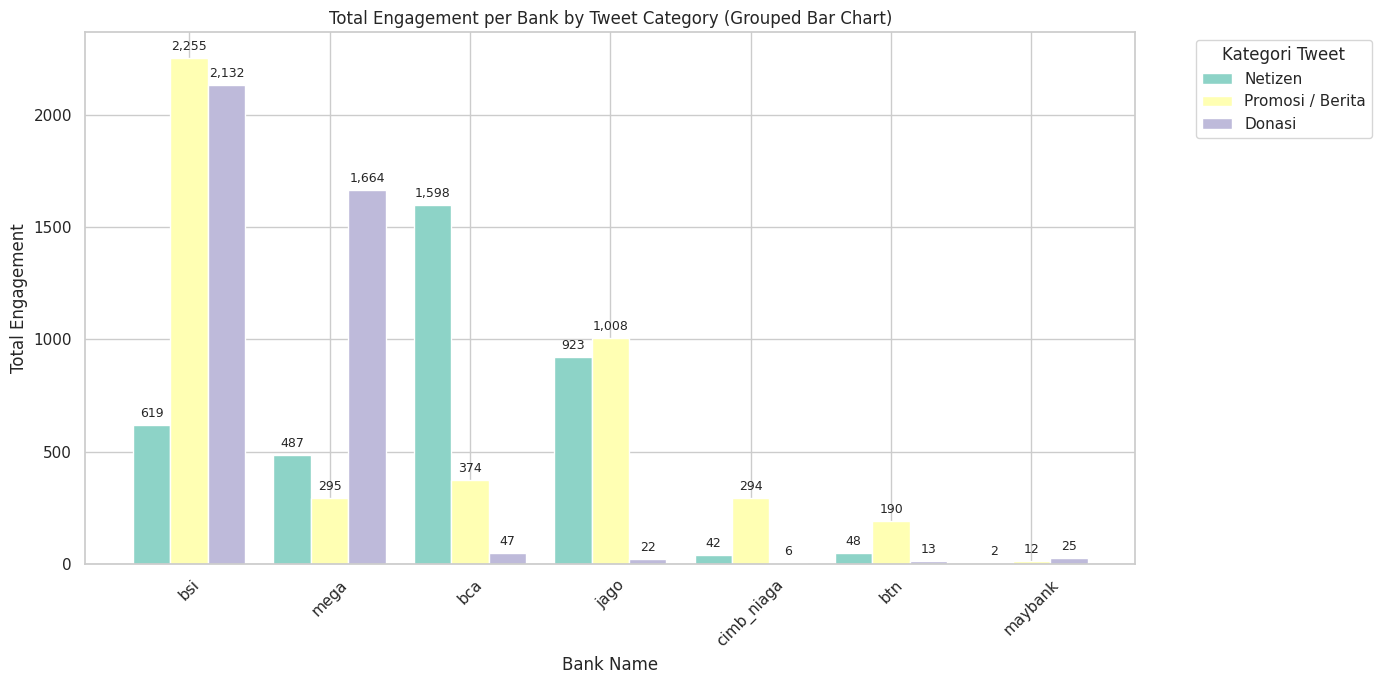

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Reorder banks in custom order ---
custom_order = ["bsi", "mega", "bca", "jago", "cimb_niaga", "btn", "maybank"]
stacked_data_sorted = stacked_data.copy()
stacked_data_sorted = stacked_data_sorted.reindex(custom_order).fillna(0)

banks = stacked_data_sorted.index.tolist()
data = stacked_data_sorted.values

# Define categories and labels
categories = stacked_data_sorted.columns.tolist()
custom_labels = {
    categories[0]: "Netizen",          # previously 1
    categories[1]: "Promosi / Berita", # previously 2
    categories[2]: "Donasi"            # previously 3
}

num_banks = len(banks)
num_categories = len(categories)
bar_width = 0.8 / num_categories
x = np.arange(num_banks)

# Plot — keep original color_map without changing or redefining
plt.figure(figsize=(14, 7))
for i, category in enumerate(categories):
    plt.bar(x + i * bar_width, data[:, i], width=bar_width,
            color=color_map[category],  # use existing color_map
            label=custom_labels[category])
    for j in range(num_banks):
        plt.text(x[j] + i * bar_width, data[j, i] + max(data.flatten()) * 0.01,
                 f'{int(data[j, i]):,}', ha='center', va='bottom', fontsize=9)

plt.xticks(x + bar_width * (num_categories - 1) / 2, banks, rotation=45)
plt.xlabel('Bank Name')
plt.ylabel('Total Engagement')
plt.title('Total Engagement per Bank by Tweet Category (Grouped Bar Chart)')
plt.legend(title='Kategori Tweet', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


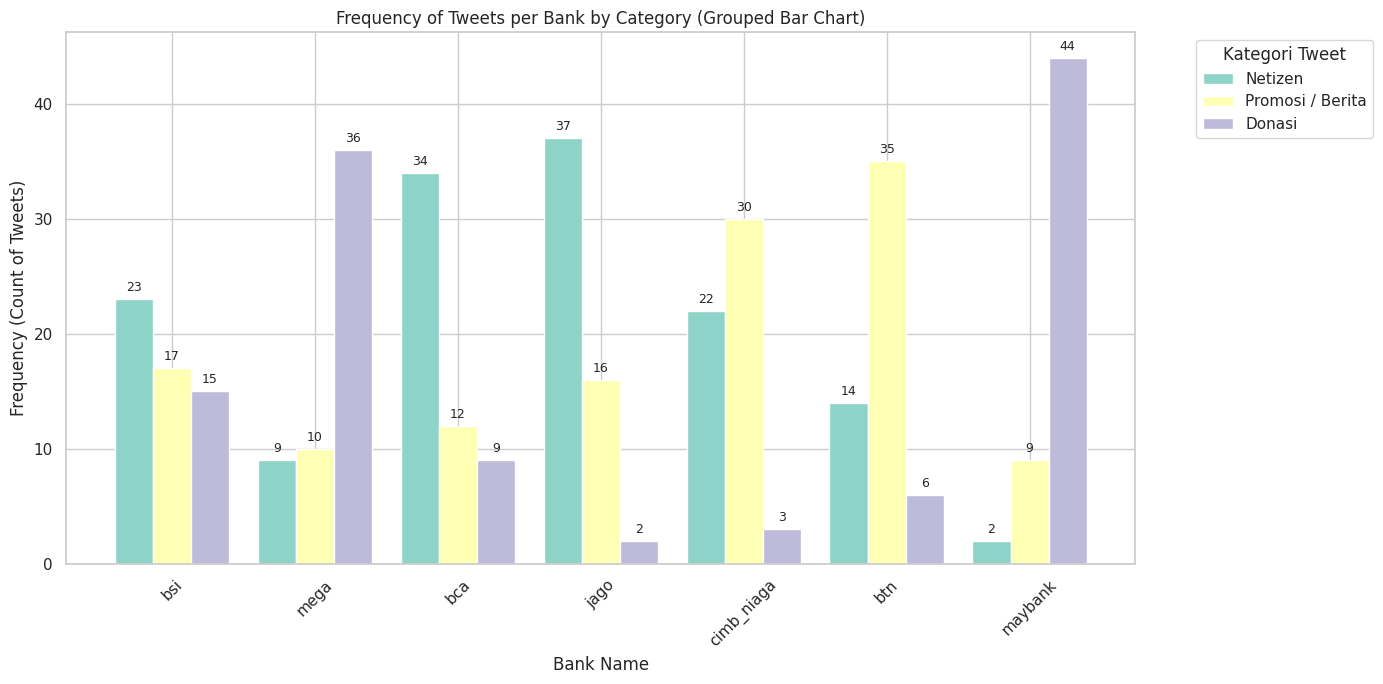

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define your custom order
custom_order = ["bsi", "mega", "bca", "jago", "cimb_niaga", "btn", "maybank"]

# Create the pivot table (frequency of tweets per category per bank)
freq_data = df.pivot_table(
    index='bank_name',
    columns='Category',
    values='full_text',   # or any non-null column
    aggfunc='count',
    fill_value=0
)

# Reindex according to custom order (fill missing banks if any)
freq_data_sorted = freq_data.reindex(custom_order).fillna(0)

banks = freq_data_sorted.index.tolist()
data = freq_data_sorted.values

# Categories and custom labels
categories = freq_data_sorted.columns.tolist()
custom_labels = {
    categories[0]: "Netizen",          # category 1
    categories[1]: "Promosi / Berita", # category 2
    categories[2]: "Donasi"            # category 3
}


# Plotting
num_banks = len(banks)
num_categories = len(categories)
bar_width = 0.8 / num_categories
x = np.arange(num_banks)

plt.figure(figsize=(14, 7))
for i, category in enumerate(categories):
    plt.bar(x + i * bar_width, data[:, i], width=bar_width,
            color=color_map[category], label=custom_labels[category])
    for j in range(num_banks):
        plt.text(x[j] + i * bar_width, data[j, i] + max(data.flatten()) * 0.01,
                 f'{int(data[j, i]):,}', ha='center', va='bottom', fontsize=9)

plt.xticks(x + bar_width * (num_categories - 1) / 2, banks, rotation=45)
plt.xlabel('Bank Name')
plt.ylabel('Frequency (Count of Tweets)')
plt.title('Frequency of Tweets per Bank by Category (Grouped Bar Chart)')
plt.legend(title='Kategori Tweet', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


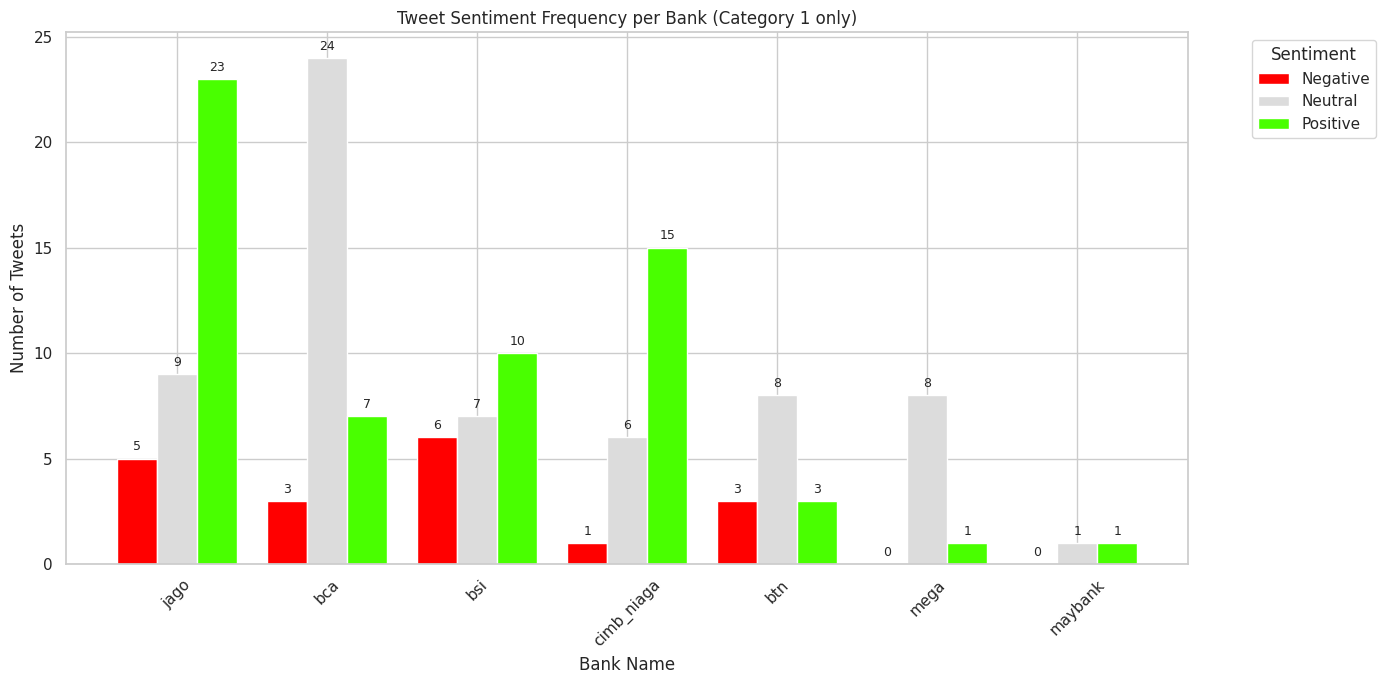

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Filter only Category == 1
df_cat1 = df[df['Category'] == 1]

# Pivot table to count frequency of each sentiment per bank
sentiment_counts = df_cat1.pivot_table(
    index='bank_name',
    columns='sentiment',
    values='full_text',  # or any non-null column
    aggfunc='count',
    fill_value=0
)

# Sort banks by total sentiment counts
sentiment_counts['Total'] = sentiment_counts.sum(axis=1)
sentiment_counts_sorted = sentiment_counts.sort_values('Total', ascending=False).drop(columns='Total')

banks = sentiment_counts_sorted.index.tolist()
data = sentiment_counts_sorted.values
categories = sentiment_counts_sorted.columns.tolist()

num_banks = len(banks)
num_categories = len(categories)
bar_width = 0.8 / num_categories
x = np.arange(num_banks)

# Define colors and labels using string keys
sentiment_colors = {
    "positive": "#49ff00",
    "neutral": "#dcdcdc",
    "negative": "#ff0000"
}
sentiment_labels = {
    "positive": "Positive",
    "neutral": "Neutral",
    "negative": "Negative"
}

plt.figure(figsize=(14, 7))

for i, sentiment in enumerate(categories):
    plt.bar(x + i * bar_width, data[:, i], width=bar_width,
            color=sentiment_colors.get(sentiment, 'blue'),
            label=sentiment_labels.get(sentiment, sentiment))

    for j in range(num_banks):
        plt.text(x[j] + i * bar_width, data[j, i] + max(data.flatten())*0.01,
                 f'{int(data[j, i]):,}', ha='center', va='bottom', fontsize=9)

plt.xticks(x + bar_width * (num_categories - 1) / 2, banks, rotation=45)
plt.xlabel('Bank Name')
plt.ylabel('Number of Tweets')
plt.title('Tweet Sentiment Frequency per Bank (Category 1 only)')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Wordcloud Sentimen dari Netizen seputar Maybank Syariah

In [ ]:
!pip install wordcloud nltk Sastrawi

import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
import nltk
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

nltk.download('punkt')
nltk.download('punkt_tab')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


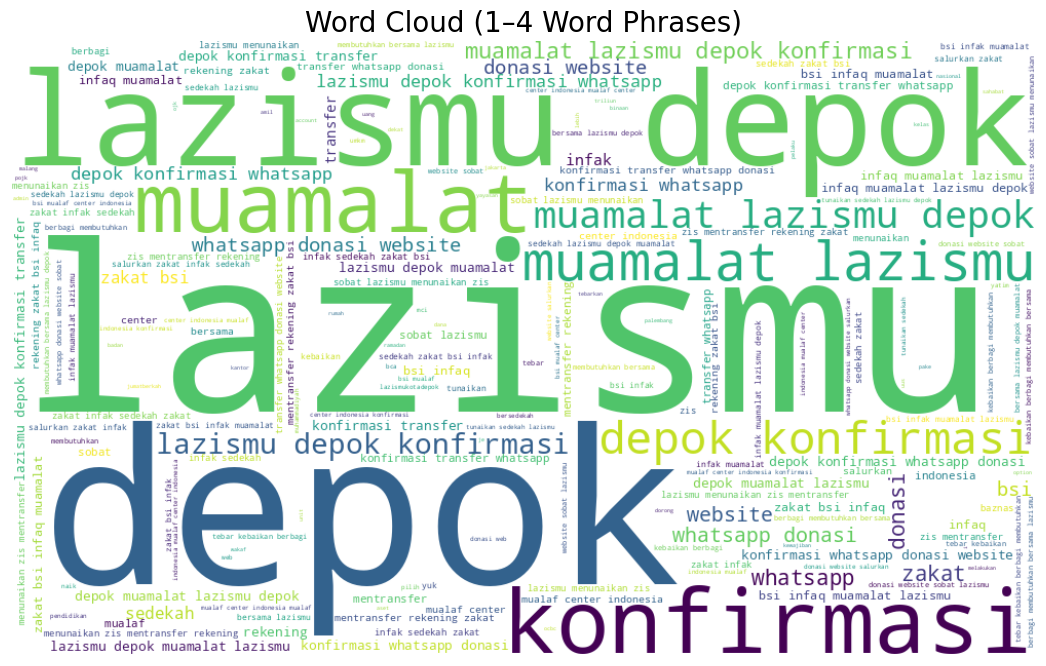

In [ ]:
# Load dataset
df = pd.read_csv("tweets-data/Engagement Sorted/combined_sorted_engagement-v3.csv")
df = df[df['bank_name'].str.lower() == 'maybank']

# Combine all text
text = " ".join(df['full_text'].dropna().astype(str).tolist()).lower()

# Tokenize
tokens = word_tokenize(text)

# Remove stopwords (Bahasa Indonesia)
factory = StopWordRemoverFactory()
default_stopwords = set(factory.get_stop_words())
custom_stopwords = {'bank', 'syariah', 'aja', 'nih', 'dong', 'kak', 'sih', 'tak', 'dgn', 'tau', 'jd', 'gk', 'gak', 'aja', 'jd', 'lh', 'lah', 'biar', 'via',
                    'jd', 'jadi', 'cm', 'cmn', 'cuma', 'cuman', 'dh', 'dah', 'kalau', 'yg', 'ga','juga', 'jg', 'nya', 'ak','aku', 'km', 'kamu', 'ni', "https",
                    'utk', 'kl', 'klo', 'emng', 'emg', 'emang', 'si', 'sih', 'tp', 'kalo', 'tu', 'trs', 'terus', 'apa', 'ap', 'dr', 'dari', 'kota', 'melalui', "maybank", "syariah"}
combined_stopwords = default_stopwords.union(custom_stopwords)
tokens = [t for t in tokens if t.isalpha() and t not in combined_stopwords]

# Generate 1–4 grams
def get_ngram_frequencies(tokens, min_n=1, max_n=4):
    all_ngrams = []
    for n in range(min_n, max_n + 1):
        n_grams = ngrams(tokens, n)
        all_ngrams += [" ".join(gram) for gram in n_grams]
    return Counter(all_ngrams)

# Count n-grams
ngram_freq = get_ngram_frequencies(tokens, min_n=1, max_n=4)

# Generate and display word cloud
wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(ngram_freq)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud (1–4 Word Phrases)", fontsize=20)
plt.show()


## n-gram (1-4 words)

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Combine all the text into one list
texts = df['full_text'].dropna().astype(str).tolist()

# Function to extract and count n-grams
def get_top_ngrams(corpus, ngram_range=(1,1), n=None):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vec.fit_transform(corpus)
    sum_words = X.sum(axis=0)
    words_freq = [(word, int(sum_words[0, idx])) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Get top 10 of each
top_1gram = get_top_ngrams(texts, ngram_range=(1,1), n=10)
top_2gram = get_top_ngrams(texts, ngram_range=(2,2), n=10)
top_3gram = get_top_ngrams(texts, ngram_range=(3,3), n=10)
top_4gram = get_top_ngrams(texts, ngram_range=(4,4), n=10)

# Create DataFrame for display
df_ngrams = pd.DataFrame({
    '1-gram': [x[0] for x in top_1gram],
    '1-gram freq': [x[1] for x in top_1gram],
    '2-gram': [x[0] for x in top_2gram],
    '2-gram freq': [x[1] for x in top_2gram],
    '3-gram': [x[0] for x in top_3gram],
    '3-gram freq': [x[1] for x in top_3gram],
    '4-gram': [x[0] for x in top_4gram],
    '4-gram freq': [x[1] for x in top_4gram],
})

# Display table
print(df_ngrams)


       1-gram  1-gram freq               2-gram  2-gram freq  \
0     syariah           62      maybank syariah           55   
1     maybank           58           kota depok           42   
2     lazismu           52         lazismu kota           41   
3       https           50  muamalat 3420003601           28   
4        kota           45   3420003601 maybank           28   
5       depok           44   syariah 2795000060           28   
6     melalui           38   2795000060 lazismu           28   
7  konfirmasi           33     depok konfirmasi           28   
8    muamalat           29            0882 9938           28   
9  3420003601           28            9938 5590           28   

                        3-gram  3-gram freq  \
0           lazismu kota depok           41   
1  muamalat 3420003601 maybank           28   
2   3420003601 maybank syariah           28   
3   maybank syariah 2795000060           28   
4   syariah 2795000060 lazismu           28   
5      279500